In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from matplotlib import pyplot as plt

# Introduction
This notebook explores the classic percolation model for bushfire modelling and considers the Poisson distribution later.

Suppose you are given an aerial image of the vegetation bordering on a town. You would like to evaluate the risk of fire starting at one end spreading all the way to the other side and causing damage to the town. A simple model is the following:

Let's divide the image into square cells like a chess board. For a cell you then look at the image and if you see some sign of vegetation (trees, greenery, bushes) you record that the cell contains burnable fuel. Do this for every cell on the board and you and up with a grid where some cells contain fuel and some don't. 

Now let's assume that only cells containing fuel can catch fire and then once it is on fire that it will spread to its four neighbours (north, south, west, east).

Now this is a simplistic model with some apparent unrealistic assumptions:

1. We are treating all vegetation as the same fuel, but obviously the type and quantity in each cell matters.
2. The fire can only spread in cardinal directions? And what about the diagonal neighbours, or if we have hexagonal shaped cells or any other type of subdivision of the plane (plane tilings).
3. Does fire always spread to all of its neighbours? There is some randomness induced by things which the model ignores, such as wind, weather, humidity etc... Regardless here lets decide to make a worst case analysis and assume that fire does always spread to all neigbhours containing fuel.

As for the first point, in a later section the case where a cell can contain a random amount of burnable fuel is explored.

In [2]:
def create_lattice(p=0.5, N=20, mode='bernoulli', lam=1):
    rng = default_rng()
        
    if mode == 'bernoulli':
        x = rng.uniform(low=0, high=1, size=(N, N))
        y = x < p
    elif mode == 'poisson':
        y = rng.poisson(lam=p, size=(N, N))
        
    elif mode == 'mixed':
        x = rng.uniform(low=0, high=1, size=(N, N))
        y1 = x < p
        y1 = y1.astype(int)
        
        y2 = rng.poisson(lam=lam, size=(N, N))
        y2 = y2.astype(int)
        
        y = np.multiply(y1, y2)
        
    return y.astype(int)

# check if node contains fuel
def burnable(node, lattice):
    return lattice[node] > 0

# returns false if index is outside of lattice
def in_lattice(index, lattice):
    m, n = lattice.shape
    i, j = index
    if not 0 <= i <= m-1 or not 0 <= j <= n-1:
        return False
    else:
        return True

def get_neighbours(node, lattice):
    # get neighbours based on reach, i.e. node value
    # same for bernoulli and poisson modes, reach = L_inf distance
    nbs = []
    i, j = node
    reach = lattice[node]
#     k + l <= reach
    for k in range(reach + 1):
        for l in range(reach + 1 - k):
            for signk in [-1, 1]:
                for signl in [-1, 1]:
                    nb = (i + signk*k, j + signl* l)
                    if in_lattice(nb, lattice):
                        nbs.append(nb)
            
    # remove duplicates from k=0 or l=0
    nbs = list(set(nbs))
    # remove original node, case k=l=0
    if node in nbs:
        nbs.remove(node)
    return nbs
    
    

In [3]:
def simulate(p, N, mode, lam=1):
    # initialize
    lattice = create_lattice(p, N, mode, lam)
    matrices = [np.copy(lattice)]
    
    front = []
    archive = []
    
    # add burnable nodes in top row to front
    I, J = np.where(lattice[:1] > 0)
    for index in zip(I, J):
        front.append(index)
        
    # spread fire until front is emtpy
    while front:
        new_front = []
        
        for node in front:
            # get neighbours before burning
            nbs = get_neighbours(node, lattice)
            lattice[node] = -1
            
            # add burnable neighbours to new front
            for nb in nbs:
                if not nb in front and not nb in archive and burnable(nb, lattice):
                    new_front.append(nb)
        
        # update archive
        archive = archive + front
        # update front
        front = new_front
        
        # save snapshot of current lattice
        mat = np.copy(lattice)
        matrices.append(mat)
        
    return matrices

In [4]:
mats = simulate(.5, 30, 'mixed', 2)

# Plotting and Animating

## Create Custom Color Map

### Bernoulli

The color map for the Bernoulli case should map:

- -1 (fire) to red
- 0 (no vegetation) to orange
- 1 (vegetation) to green

In [5]:
mats_bernoulli = simulate(0.5, 30, 'bernoulli')

In [6]:
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [7]:
red = np.array([colors.to_rgba('firebrick')])
brown = np.array([colors.to_rgba('orange')])
greens = cm.get_cmap('Greens', 256)



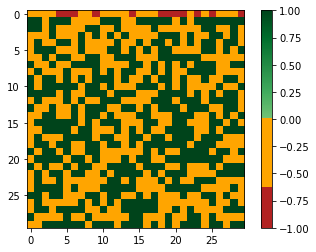

In [8]:
colors_bernoulli = greens(np.linspace(0, 1, 256))
colors_bernoulli[:48, :] = red
colors_bernoulli[48:129, :] = brown
cmp_bernoulli = ListedColormap(colors_bernoulli)

plt.imshow(mats_bernoulli[1], cmap = cmp_bernoulli, vmin = -1)
plt.colorbar()

### Poisson

For the Poisson case we want:

- -1 to red
- 0 to orange
- 1-10 to green, going from light green to dark green
 
Since in the last case we want gradient, it is easier to use a segmented color map and providing nodes for the gradient ranges.

Note: We assume in this notebook that values above 10 will rarely appear. If this does not hold, then the range has to be increased beyond 10. Larger values appear with bigger lattices but mostly with higher lambda. This is especially relevant for the masked lattice case where we allow for higher lambdas but use a Bernoulli mask to keep expected value small.

In [9]:
mats_poisson = simulate(0.5, 30, 'poisson')

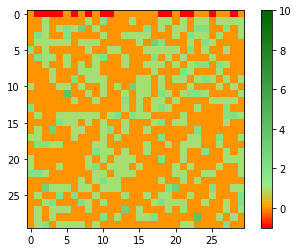

In [10]:
colors = ["red", "orange", "lightgreen", "darkgreen"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

nodes = [0.0, 0.1, 0.2, 1.0]
cmp_poisson = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))


plt.imshow(mats_poisson[1], cmap = cmp_poisson, vmin = -1, vmax = 10)
plt.colorbar()

# Create Animation

In [11]:
from matplotlib.animation import FuncAnimation

In [12]:
import matplotlib.animation as animation
from IPython import display

In [13]:
def animate_grid(ls_mats, mode):
    if mode == 'bernoulli':
        cmap = cmp_bernoulli
        vmax = None
    elif mode == 'poisson':
        cmap  = cmp_poisson
        vmax = 10
    
    ims = []
    
    # plot in for parameter values .2, .4, .6, .8 in a 2x2 grid
    fig, ax = plt.subplots(2, 2)

In [123]:
def animate(mats, mode):
    
    if mode == 'bernoulli':
        cmap = cmp_bernoulli
        vmax = None
    elif mode == 'poisson':
        cmap  = cmp_poisson
        vmax = 10
        
    ims = []
    fig,axs = plt.subplots()
    axs.set_xticks([])
    axs.set_yticks([])
    
    for i, mat in enumerate(mats):
        im = plt.imshow(mat, cmap = cmap, vmin = -1, vmax=vmax, animated=True)

        if i==0:
            im = plt.imshow(mat, cmap = cmap, vmin = -1, vmax=vmax, animated=True)
            plt.colorbar()
        ims.append([im])
            
    anim = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    plt.close()
    
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    
# animate 4 cases of spreading in a 2x2 grid
def animate_22(ls_mats, mode):
    if len(ls_mats) != 4:
        print("Input must be a list with four matrix sequences")
        return
        
    if mode == 'bernoulli':
        cmap = cmp_bernoulli
        vmax = None
    elif mode == 'poisson':
        cmap  = cmp_poisson
        vmax = 10
        
    
    # pad matrices
    ls_mats_padded = pad_matrices(ls_mats)
    
    
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    fig.subplots_adjust(hspace=0.5)
    
    ims = []
    
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    
    for i in range(len(ls_mats_padded[0])):
        mat00 = ls_mats_padded[0][i]
        mat01 = ls_mats_padded[1][i]
        mat10 = ls_mats_padded[2][i]
        mat11 = ls_mats_padded[3][i]

#                 im = plt.imshow(mat, cmap = cmap, vmin = -1, vmax=vmax, animated=True)

        im00 =axs[0].imshow(mat00, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
        im01 =axs[1].imshow(mat01, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
        im10 =axs[2].imshow(mat10, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
        im11 =axs[3].imshow(mat11, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
        
        if i==0:
            im00 =axs[0].imshow(mat00, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
            im01 =axs[1].imshow(mat01, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
            im10 =axs[2].imshow(mat10, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
            im11 =axs[3].imshow(mat11, cmap=cmap, vmin=-1, vmax=vmax, animated=True)
            fig.colorbar(im00,ax=axs, orientation='horizontal')  

        ims.append([im00, im01, im10, im11])

    anim = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    plt.close()

    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    

def pad_matrices(ls_mats):

    max_length = max([len(mats) for mats in ls_mats])

    ls_mats_padded = [mats + [mats[-1]]*(max_length - len(mats)) for mats in ls_mats]
    
    return ls_mats_padded

In [124]:
size = 50
mats_bernoulli = [simulate(p, size, 'bernoulli') for p in np.arange(.2, 1, step=.2)]
animate_22(mats_bernoulli, 'bernoulli')


In [16]:
size = 50
mats_bernoulli = [simulate(p, size, 'poisson') for p in np.arange(.2, 1, step=.2)]
animate_22(mats_bernoulli, 'poisson')


# Data Analysis 

For site percolation we want to know how likely a fire is to reach the bottom side depending on p for Bernoulli, or lambda for Poisson.

In [17]:
def reached_bottom(mat):
    fires = mat[-1:] == -1
    return fires.any()

def get_data(P, N, iterations, mode, lam=1):
    df = pd.DataFrame([], columns=['p', 'crossing', 'mode'])
    for p in P:
        for i in range(iterations):
            mats = simulate(p, N, mode, lam)
            new_row = {'p':p, 'crossing':reached_bottom(mats[-1]), 'mode':mode}
            df = df.append(new_row, ignore_index=True)
    return df

## Bernoulli

In [18]:
iterations = 3
N = 20
P = np.linspace(0.1, 1, 20)
mode = 'bernoulli'
df = pd.DataFrame([], columns=['p', 'crossing', 'mode'])

df = get_data(P, N, iterations, mode)

Text(0, 0.5, 'crossing probability')

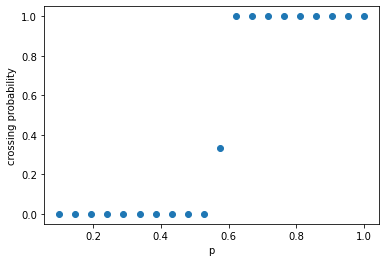

In [19]:
averages = df[['p', 'crossing']].groupby('p').mean()

averages['p'] = averages.index

plt.subplots()
plt.scatter('p', 'crossing', data=averages)
plt.xlabel('p')
plt.ylabel('crossing probability')

Instead of a steady increase with p, we see a sudden increase starting at the threshold around p = 0.5, as predicted by Percolation theory.

## Poisson

In [20]:
iterations = 3
N = 15
P = np.linspace(0.1, 1, 20)
mode = 'poisson'
df = pd.DataFrame([], columns=['lambda', 'crossing', 'mode'])

df = get_data(P, N, iterations, mode)

Text(0, 0.5, 'crossing probability')

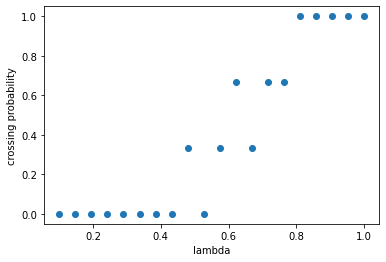

In [22]:
averages = df[['p', 'crossing']].groupby('p').mean()

averages['p'] = averages.index

plt.subplots()
plt.scatter('p', 'crossing', data=averages)
plt.xlabel('lambda')
plt.ylabel('crossing probability')

Similary to the Bernoulli case, here we see the same jump starting at same threshold lambda = 0.5. lambda and p are different parameters of two different distributions but connected as they are the expected value of their respective distributions.

# Masked distribution

In this section we combine the Poisson model above with a Bernoulli mask, i.e. each cell in the grid can be on or off according to a Bernoulli distribution, and a cell that is turned on has a random amount of fuel according to a Poisson distribution. Intuitively one can imagine a satellite image from which we can read off the amount of canopy; however the amount of vegetation covered under each piece of the canopy is unknown to us and we only know the distribution of vegetation in such a case. This distribution may be better approximated by a Gaussian, but under certain circumstances a Poisson distribution is very close to the Gaussian, but easier to analyze due to having only one parameter instead of two for the Gaussian.

## Single iteration

In [125]:
p = 0.5
I = 2
N = 50
lat_ber = create_lattice(p, N, 'bernoulli')
lat_pois = create_lattice(I, N, 'poisson')

In [126]:
mats = simulate(0.05, N, 'mixed', 5)

In [127]:
animate(mats, 'poisson')

## Critical Boundary

In the Bernoulli and Poisson cases we had a critical value for their respective parameters. In the masked case we have two parameters so we expect a critical boundary in the shape of a curve. In this section we sample p and lambda on a grid to figure out how this critical boundary looks like.

In [115]:
# define sampling parameters
iterations = 25
N = 30
P = np.linspace(0.1, 1, 20)
L = np.linspace(0, 5, 20)
mode = 'mixed'

# initialize data frame to store sampling results
df = pd.DataFrame([], columns=['p', 'lambda', 'crossing', 'mode'])

In [116]:
# create sampling grid for p and lambda
Ps, Ls = np.meshgrid(P, L, indexing='ij')

for i in range(len(P)):
    for j in range(len(L)):
        p = Ps[i,j ]
        lam = Ls[i, j]
        mats = simulate(p, N,'mixed', lam)
        new_row = {'p':p, 'lambda': lam, 'crossing': reached_bottom(mats[-1]), 'mode': mode}
        df = df.append(new_row, ignore_index=True)

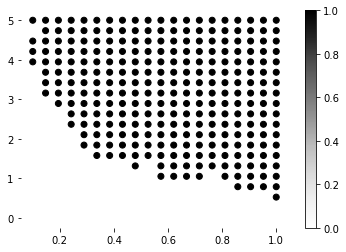

In [136]:
# compute average crossing probability by parameters
df2 = df.groupby(['p', 'lambda']).crossing.mean().reset_index()

# plot results
fig, ax = plt.subplots()

for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set_visible(False)
    
plt.scatter('p', 'lambda', c='crossing', data=df2, cmap='Greys')
plt.colorbar()

Note that all we see are white and black dots, even though we are using a continuous grey scale color map. This indicates that the crossing probability jumps suddenly from 0 to 1.

## Data vs Theory

As the last step we compare the empirical results above with the critical boundary curve predicted by theory.

A crossing happens exactly when a giant connected component emerges in the network of vegetation, spanning from the top edge to the bottom edge. \
Theory predicts that such a giant component emerges when the average node degree is greater or equal to two, i.e. $ \mathbb{E}[d] \geq 2, $ \
where d is the degree of a randomly chosen cell. The critical boundary occurs when the above is satisfied as an equality.

We set
\begin{align*}
2 & =  \mathbb{E}[d] \\
  &  = \mathbb{E}[reach] \cdot p
\end{align*}

where the second line follows since reach and fill are independent. 

It remains to compute $\mathbb{E}[reach]$:

\begin{align*}
\mathbb{E}[reach]
& = \sum_{k = 0}^{\infty} p(k) \cdot reach(k) \\
&= \sum_{k = 0}^{\infty} \exp(-\lambda) \frac{\lambda^k}{k!}2k(k+1) \\
&\approx \sum_{k = 0}^{\infty} \exp(-\lambda) \frac{\lambda^k}{k!}2k(k-1) \\
&= 2 \exp(-\lambda) \sum_{k = 2}^{\infty} \frac{\lambda^k}{(k-2)!} \\
&= 2 \exp(-\lambda) \sum_{k = 0}^{\infty} \lambda^2 \frac{\lambda^k}{k!} \\
&= 2 \exp(-\lambda) \lambda^2 \exp(\lambda) \\
&= 2 \lambda^2
\end{align*}




where we use in line 2 that
$$
reach(k) = 2k(k+1).
$$

We obtain the critical boundary at

\begin{align*}
& 2 = p \cdot 2 \lambda^2 \\
\Leftrightarrow & \lambda = \frac{1}{\sqrt{p}}
\end{align*}


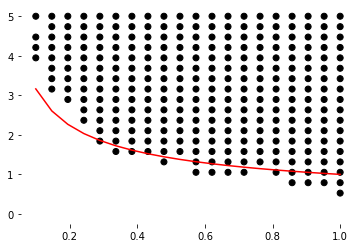

In [137]:
# plot results

    
fig, ax = plt.subplots()

for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set_visible(False)

    
plt.scatter('p', 'lambda', c='crossing', data=df2, cmap='Greys')

# plot 1/sqrt(x), boundary predicted by theory
X = np.linspace(0.1, 1, 20)
Y = [1/np.sqrt(x) for x in X]

plt.plot(X, Y, color='r')


The fit is not perfect, error could origininate from the approximation step or theory assuming random graph.